# Continuous Control

---

In this notebook, it will be learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

When finished, you can close the environment.

### Training


In [1]:
import sys
import numpy as np
import pandas as pd
import torch
from collections import deque
import progressbar as pb
import time
import parquet
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
import config
from ddpg_agent_multi import Agent

In [2]:
# Load simulation environment
#env = UnityEnvironment(file_name='C:/Users/Simon/PYTHON/Deep_Reinforcement_Learning_Nanodegree_UDACITY/Projet2_Reacher/Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='C:/Users/Simon/PYTHON/Deep_Reinforcement_Learning_Nanodegree_UDACITY/Projet2_Reacher/Reacher_Windows_x86_64 (20 agents)/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [4]:
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=1, episodes=config.n_episodes)

In [5]:
def ddpg(episodes=config.n_episodes,  max_t=config.max_t, moving_average_period=config.moving_average_period, print_interval=config.print_interval, target_score = config.target_score):
    """DDQN Algorithm.
    
    Params
    ======
        episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        moving_average_period (int): frequency of printing information throughout iteration
        print_interval (int): interval at which information is printed
        target_score (int): goal that stops learning
        """
    
    agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=1, episodes=episodes)

    # Record the start time before training begins
    start_time = time.time()

    # Initialize lists and dataframe
    episodes_list = []
    time_list = []
    scores = []
    scores_deque = deque(maxlen=moving_average_period)
    critic_losses = []
    critic_losses_deque = deque(maxlen=moving_average_period)
    actor_losses = []
    actor_losses_deque = deque(maxlen=moving_average_period)
    noise_sigma = []
    df = pd.DataFrame(columns=['Episode', 'Score', 'Average Scores', 'Actor losses', 'Average Actor losses', 'Critic losses', 'Average Critic losses', 'Noise Sigma', 'PER Beta', 'Time'])
    PER_df = pd.DataFrame()
    param_df = pd.DataFrame()
    
    
    # Learning
    for i_episode in range(1, episodes+1):
        # Reset the enviroment
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment 
        # get the the first state 
        cur_states = env_info.vector_observations               # get the current state (for each agent)
        # Reset the noise process associated with the agent for stochastic exploration
        agent.reset(i_episode)      
        score = np.zeros(num_agents)                            # initialize the score (for each agent)
        critic_loss = np.zeros(num_agents)
        actor_loss = np.zeros(num_agents)
        
        time_episode_start = time.time()
        num_steps = 0
            
        for t in range(1, max_t+1):
            # Predict the best action for the current state. 
            actions = agent.act(cur_states) # actions = agent.act(cur_states)    
            # Action is performed and new state, reward are received. 
            env_info = env.step(actions)[brain_name]             # send all actions to the environment
            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = env_info.rewards                           # get reward (for each agent)
            dones = env_info.local_done                          # see if episode finished
               
            ## Store experience of all the agents in the experience replay and take step with agent (including learning)
            agent.step_memory_and_learn(states=cur_states, actions=actions, rewards=rewards, next_states=next_states, dones=dones) # take step with agent (including learning)
            # roll over new state
            cur_states = next_states
            
            # update indicators 
            score += np.array(rewards)                           # update the score (for each agent)

            if agent.last_critic_loss is not None:
                critic_loss += agent.last_critic_loss            # Access the last loss records of the agents
            else :
                critic_loss += np.NaN                            # or 0 to indicate the absence of loss calculation and avoid an error  
            if agent.last_actor_loss is not None: # Access the last loss records of the agents
                actor_loss += agent.last_actor_loss
            else :
                actor_loss += np.NaN
            
            num_steps += 1
            if np.any(dones):                                     # exit loop if timestep finished
                break
                
        # Time mesuremenent       
        time_episode_str = time.strftime('%Mm%Ss', time.gmtime(time.time() - time_episode_start))

        # append data in lists
        episodes_list.append(i_episode)
        time_list.append(time_episode_str)
        scores.append(np.mean(score))                             # score = list of num_agents score
        scores_deque.append(np.mean(score))
        critic_losses.append(np.mean(critic_loss/num_steps))      # divide by num_steps to normalize in order to compare data  
        critic_losses_deque.append(np.mean(critic_loss/num_steps))
        actor_losses.append(np.mean(actor_loss/num_steps))
        actor_losses_deque.append(np.mean(actor_loss/num_steps))   
        noise_sigma.append(np.mean(agent.noise.sigma))

        warnings.filterwarnings("ignore", category=RuntimeWarning) # Temporarily suppress the display of RuntimeWarning warnings (error=mean(Nan) in 1st episode)
        critic_losses_deque_mean = np.nanmean(critic_losses_deque)
        actor_losses_deque_mean = np.nanmean(actor_losses_deque)
        warnings.filterwarnings("default", category=RuntimeWarning) # Restore default RuntimeWarning behavior
            
        # Record metrics in a DataFrame
        episode_data = {
                'Episode': i_episode,
                'Score': scores[-1],  
                'Average Scores': np.mean(scores_deque),
                'Actor losses': actor_losses[-1],
                'Average Actor losses': actor_losses_deque_mean,
                'Critic losses': critic_losses[-1],
                'Average Critic losses': critic_losses_deque_mean, 
                'Noise Sigma': noise_sigma[-1],
                'PER Beta': agent.beta,
                'Time': time_list[-1]
            }
        df = df.append(episode_data, ignore_index=True)
        
        # Record weights and gradients in a DataFrame
        agent.record_weights_and_gradients(i_episode)
        episode_metrics = pd.DataFrame([agent.weights_data_episode])                      
        param_df = pd.concat([param_df, episode_metrics], ignore_index=True)

        # Temporary print 
        if i_episode % print_interval != 0:
            current_time = passed_time(start_time, format_type="hours_minutes_seconds")
            sys.stdout.write(f"\rEpisode: {i_episode} ({current_time})\tAvg Score: {np.mean(scores_deque):.2f}\tScore: {np.mean(score):.2f}\tSigma: {agent.noise.sigma:.3f}\tBeta: {agent.beta:.3f}\tAvg Actor Loss: {actor_losses_deque_mean:.3f}\tAvg Critic Loss: {critic_losses_deque_mean:.5f}") 
            sys.stdout.flush()
            
        # Permanent print and save data
        else:
            current_time = passed_time(start_time, format_type="hours_minutes")
            print(f"\rEpisode: {i_episode} ({current_time})\tAverage Score: {np.mean(scores_deque):.2f}\tScore: {np.mean(score):.2f}\tSigma: {agent.noise.sigma:.3f}\tBeta: {agent.beta:.3f}\tAvg Actor Loss: {actor_losses_deque_mean:.3f}\tAvg Critic Loss: {critic_losses_deque_mean:.5f}")  
            save_data(df, param_df, agent.weight_magnitudes, agent.td_errors_history)

        # Print - Environment solved 
        if np.mean(scores_deque) >= target_score:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
    
    # Save data to parquet       
    save_data(df, param_df, agent.weight_magnitudes, agent.td_errors_history)

    # Print total execution time
    end_time = time.time()
    learning_time = (end_time - start_time)/60
    current_time = passed_time(start_time, format_type="hours_minutes")
    print(f'\n\nExecution time : {current_time}')

    # Print hyperparameters
    print("\n-----Project rules and hyperparameters :-----")
    for name, value in vars(config).items():
        if not name.startswith('__'):
            print(f"{name} = {value}")
            
    return agent.beta_history, agent.weight_magnitudes, agent.td_errors_history


def save_data(df, param_df, weight_magnitudes, td_errors_history):
    # save list to DataFrames
    df.to_parquet('results.parquet')
    param_df.to_parquet('gradients_bias.parquet')
    PER_dic = {
            'weight_magnitudes': weight_magnitudes,  
            'Average td_errors_history': td_errors_history,
            }
    PER_df = pd.DataFrame(PER_dic)
    PER_df.to_parquet('PER.parquet')
    # save the weights
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    # save hyperparameter values
    with open('config_values.txt', 'w') as file:
        for name, value in vars(config).items():
            if not name.startswith('__'):  
                file.write(f"{name} = {value}\n")  

def passed_time(start_time, format_type="hours_minutes_seconds"):
    elapsed_seconds = int(time.time() - start_time)
    hours, remainder = divmod(elapsed_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    if format_type == "seconds":
        return f"{elapsed_seconds} secondes"
    elif format_type == "minutes":
        total_minutes = hours * 60 + minutes
        return f"{total_minutes} minutes"
    elif format_type == "hours_minutes":
        return f"{hours}h{minutes}m"
    #  Default format includes hours, minutes and seconds
    return f"{hours}h{minutes}m{seconds}s"


In [6]:
# Start the DDPG algorithm with specified parameters
beta_history, weight_magnitudes, td_errors_history = ddpg(episodes=config.n_episodes, max_t=config.max_t, moving_average_period=config.moving_average_period, \
                     print_interval=config.print_interval, target_score = config.target_score)

Episode: 10 (0h18m)	Average Score: 1.08	Score: 2.11	Sigma: 0.160	Beta: 0.455	Avg Actor Loss: 0.028	Avg Critic Loss: 0.00002
Episode: 20 (1h1m)	Average Score: 5.16	Score: 17.32	Sigma: 0.128	Beta: 0.509	Avg Actor Loss: -0.024	Avg Critic Loss: 0.00007
Episode: 30 (2h9m)	Average Score: 13.70	Score: 37.86	Sigma: 0.103	Beta: 0.564	Avg Actor Loss: -0.121	Avg Critic Loss: 0.00013
Episode: 40 (3h41m)	Average Score: 19.92	Score: 38.12	Sigma: 0.082	Beta: 0.618	Avg Actor Loss: -0.260	Avg Critic Loss: 0.00019
Episode: 50 (5h38m)	Average Score: 23.67	Score: 38.81	Sigma: 0.066	Beta: 0.673	Avg Actor Loss: -0.421	Avg Critic Loss: 0.00023
Episode: 60 (7h56m)	Average Score: 26.23	Score: 38.80	Sigma: 0.053	Beta: 0.727	Avg Actor Loss: -0.590	Avg Critic Loss: 0.00025
Episode: 70 (10h9m)	Average Score: 28.10	Score: 39.13	Sigma: 0.042	Beta: 0.782	Avg Actor Loss: -0.767	Avg Critic Loss: 0.00024
Episode: 80 (12h17m)	Average Score: 29.43	Score: 39.07	Sigma: 0.034	Beta: 0.836	Avg Actor Loss: -0.943	Avg Critic Los

In [7]:
env.close()

In [8]:
df = pd.read_parquet('results.parquet')
#df.head(3)

In [9]:
param_df = pd.read_parquet('gradients_bias.parquet') 
#param_df.head(3)

In [10]:
PER_df = pd.read_parquet('PER.parquet')
#df.head(3)

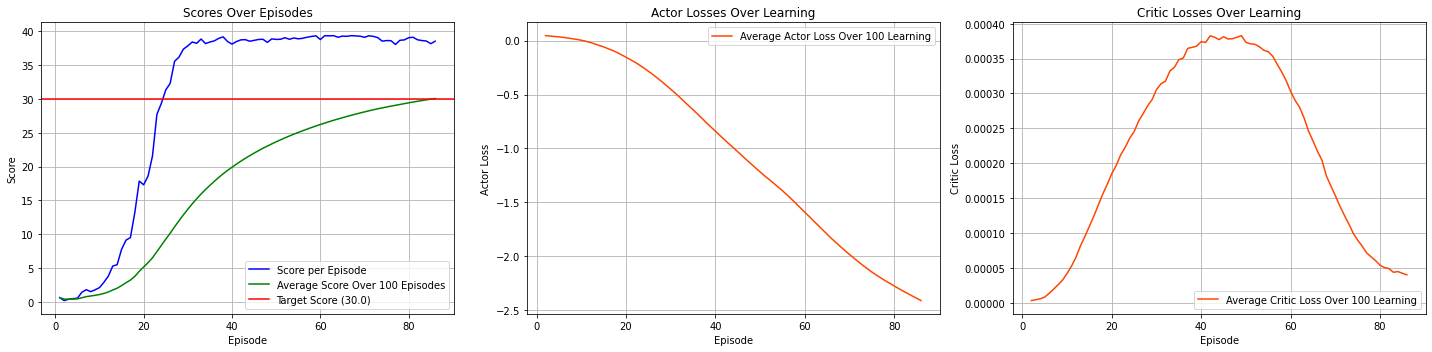

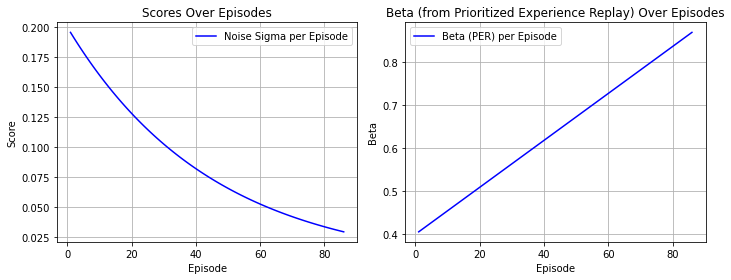

In [11]:
### plot monitored indicators

## Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5)) # 1 row, 3 columns

# Plot for scores and average scores with a red line indicating the target score of 30.0
axs[0].plot(df['Episode'], df['Score'], label='Score per Episode', color='blue')
axs[0].plot(df['Episode'], df['Average Scores'], label='Average Score Over 100 Episodes', color='green')
axs[0].axhline(y=30.0, color='red', linestyle='-', label='Target Score (30.0)')
axs[0].set_title('Scores Over Episodes')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Score')
axs[0].legend()
axs[0].grid(True)

# Plot for Actor losses and average Actor losses
axs[1].plot(df['Episode'], df['Actor losses'], label='Average Actor Loss Over 100 Learning', color='orangered')
axs[1].set_title('Actor Losses Over Learning')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Actor Loss')
axs[1].legend()
axs[1].grid(True)

# Plot for Critic losses and average Actor losses
axs[2].plot(df['Episode'], df['Critic losses'], label='Average Critic Loss Over 100 Learning', color='orangered')
axs[2].set_title('Critic Losses Over Learning')
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Critic Loss')
axs[2].legend()
axs[2].grid(True)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


## Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) # 1 row, 2 columns

# Plot for Noise Sigma
axs[0].plot(df['Episode'], df['Noise Sigma'], label='Noise Sigma per Episode', color='blue')
axs[0].set_title('Scores Over Episodes')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Score')
axs[0].legend()
axs[0].grid(True)

# Plot for PER Beta
axs[1].plot(df['Episode'], df['PER Beta'], label='Beta (PER) per Episode', color='blue')
axs[1].set_title('Beta (from Prioritized Experience Replay) Over Episodes')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Beta')
axs[1].legend()
axs[1].grid(True)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

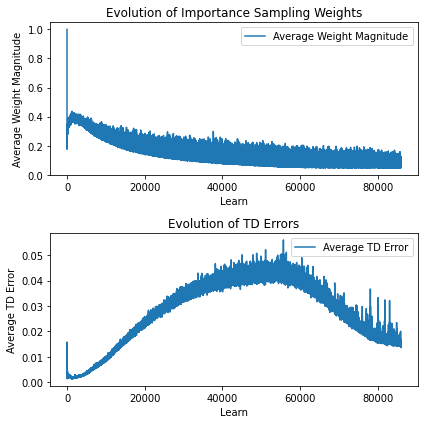

In [12]:
def plot_per_parameters(beta_history, weight_magnitudes, td_errors_history):
    
    fig, axs = plt.subplots(2, 1, figsize=(6, 6))

    axs[0].plot(range(1, len(weight_magnitudes) + 1), weight_magnitudes, label='Average Weight Magnitude')
    axs[0].set_title('Evolution of Importance Sampling Weights')
    axs[0].set_xlabel('Learn')
    axs[0].set_ylabel('Average Weight Magnitude')
    axs[0].legend()

    axs[1].plot(range(1, len(td_errors_history) + 1), td_errors_history, label='Average TD Error')
    axs[1].set_title('Evolution of TD Errors')
    axs[1].set_xlabel('Learn')
    axs[1].set_ylabel('Average TD Error')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    
plot_per_parameters(beta_history, weight_magnitudes, td_errors_history)

In [13]:
raw_param_df = pd.read_parquet('gradients_bias.parquet', engine='auto') 

def rezie_data(param_df):
    # Load dataframe
    #param_df = pd.read_parquet('gradients_bias.parquet')
    
    # Initialize
    all_data = []
    
    # Itérer sur chaque enregistrement dans votre DataFrame
    for index, row in param_df.iterrows():
        # Extracts weight and gradient data for actor and critic
        for weight_data in row['actor_weights']:
            weight_data['episode'] = row['episode']
            weight_data['type'] = 'actor'
            weight_data['param_type'] = 'weight'
            all_data.append(weight_data)
    
        for grad_data in row['actor_gradients']:
            grad_data['episode'] = row['episode']
            grad_data['type'] = 'actor'
            grad_data['param_type'] = 'gradient'
            all_data.append(grad_data)
    
        for weight_data in row['critic_weights']:
            weight_data['episode'] = row['episode']
            weight_data['type'] = 'critic'
            weight_data['param_type'] = 'weight'
            all_data.append(weight_data)
    
        for grad_data in row['critic_gradients']:
            grad_data['episode'] = row['episode']
            grad_data['type'] = 'critic'
            grad_data['param_type'] = 'gradient'
            all_data.append(grad_data)
    
    combined_df = pd.DataFrame(all_data)
    
    weights_pivot = combined_df.pivot_table(index=['layer', 'episode', 'type'], values=['weight_mean', 'weight_std'], aggfunc='first').reset_index()
    grads_pivot = combined_df.pivot_table(index=['layer', 'episode', 'type'], values=['grad_mean', 'grad_std'], aggfunc='first').reset_index()
    merged_df = pd.merge(weights_pivot, grads_pivot, on=['layer', 'episode', 'type'], how='left')
    merged_df.fillna(0, inplace=True)    
    merged_df.sort_values(by='episode', ascending=True, inplace=True)
    
    # Save DataFrame
    merged_df.to_csv('combined_data.csv', index=False)
    
    return merged_df

param_df = rezie_data(raw_param_df)
param_df.head(3)

,layer,episode,type,weight_mean,weight_std,grad_mean,grad_std
0,bn1.bias,1,actor,0.030081,0.076141,-1.160191e-06,0.000009
173,bn1.weight,1,critic,0.546051,0.304850,-8.068891e-06,0.000436
172,bn1.weight,1,actor,0.631650,0.308466,-8.342168e-07,0.000005


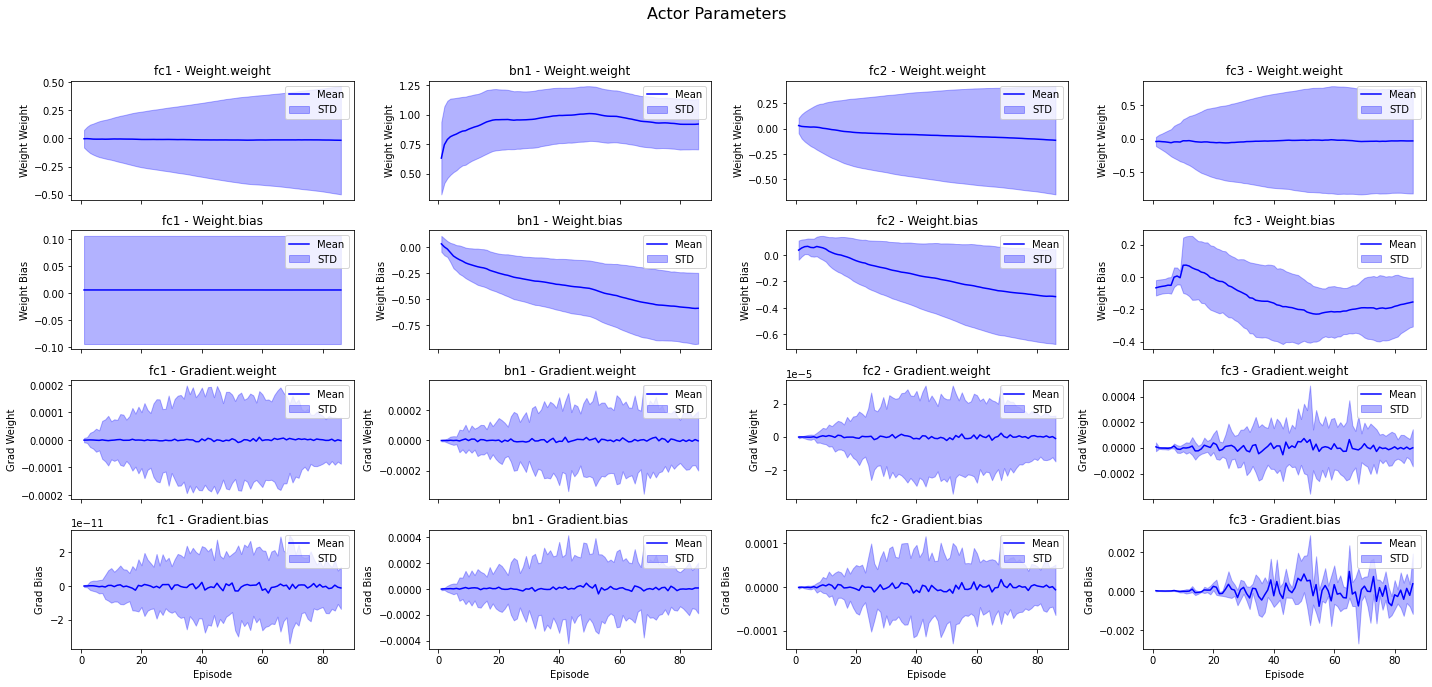

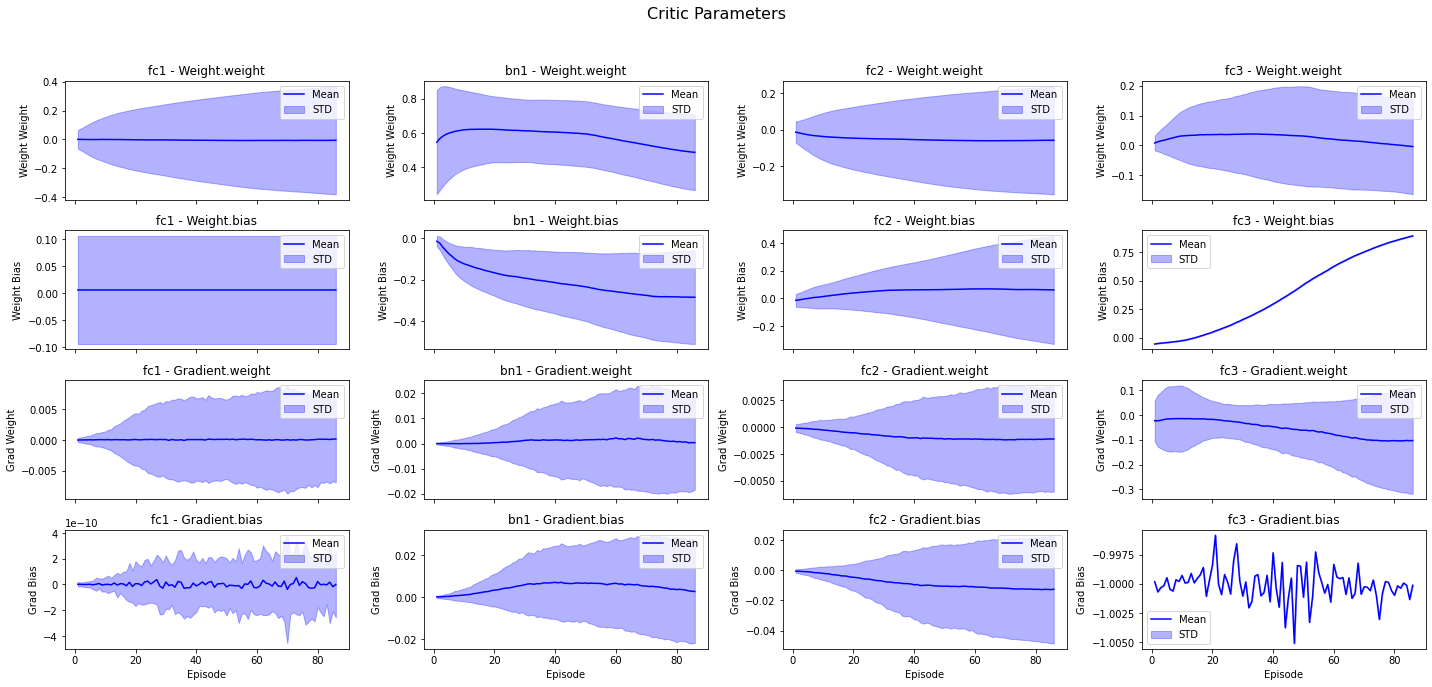

In [14]:
def plot_parameters(df, actor_or_critic, title):
    # Filter data for actor or critic only
    df_filtered = df[df['type'] == actor_or_critic]

    # Assuming we have two fc layers and one bn layer as per the description
    layers = ['fc1','bn1', 'fc2', 'fc3']
    
    # Set up the plot grid
    fig, axes = plt.subplots(4, len(layers), figsize=(20, 10), sharex=True)  # Adjust figsize as needed
    fig.suptitle(title, fontsize=16)

    # Row titles
    row_titles = ['Weight.weight', 'Weight.bias', 'Gradient.weight', 'Gradient.bias'] #Bias(weight) Mean±STD
    
    # Plot each parameter type in its row
    for i, row_title in enumerate(row_titles):
        for j, layer in enumerate(layers):
            ax = axes[i, j]
            # Select the appropriate data for the current layer
            if 'Weight.' in row_title:
                data_type = 'weight'
            #else:
            if 'Gradient.' in row_title:
                data_type = 'grad'
            
            param_type = 'bias' if '.bias' in row_title else 'weight'
            layer_data = df_filtered[df_filtered['layer'].str.contains(layer) & df_filtered['layer'].str.contains(param_type)]

            # Plot the lineplot for the mean values
            sns.lineplot(ax=ax, data=layer_data, x='episode', y=f'{data_type}_mean', label='Mean', color='blue')
            
            # Plot the fill_between for the std deviation
            ax.fill_between(layer_data['episode'], layer_data[f'{data_type}_mean'] - layer_data[f'{data_type}_std'],
                            layer_data[f'{data_type}_mean'] + layer_data[f'{data_type}_std'], alpha=0.3, color='blue', label='STD')
            
            # Set titles and labels
            ax.set_title(f'{layer} - {row_title}')
            ax.set_xlabel('Episode')
            ax.set_ylabel(f'{data_type.capitalize()} {param_type.capitalize()}')
            ax.legend()

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Apply the function to the actual DataFrame to generate plots for 'actor' and 'critic'
plot_parameters(param_df, 'actor', 'Actor Parameters')
print()
plot_parameters(param_df, 'critic', 'Critic Parameters')

### Watch a Smart Agent

In [15]:
import sys
import numpy as np
import pandas as pd
import torch
from collections import deque
import progressbar as pb
import time
import parquet
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
import config
from ddpg_agent_multi import Agent

In [16]:
# Load simulation environment
#env = UnityEnvironment(file_name='C:/Users/Simon/PYTHON/Deep_Reinforcement_Learning_Nanodegree_UDACITY/Projet2_Reacher/Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='C:/Users/Simon/PYTHON/Deep_Reinforcement_Learning_Nanodegree_UDACITY/Projet2_Reacher/Reacher_Windows_x86_64 (20 agents)/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

OSError: handle is closed

In [ ]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

In [ ]:
# Create an instance of the agent (make sure it's the same as the one we trained)
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=1, episodes=config.n_episodes)

# Load the trained weights from file

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))

In [ ]:
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [ ]:
# Set the network to evaluation mode
#agent.actor_local.eval()
#agent.critic_local.eval()
for episode in range(2):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    cur_states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(cur_states, add_noise=False)           ## select actions from DDPG policy
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += rewards                                  # update the score (for each agent)
        cur_states = next_states                              # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()